## Setup

In [1]:
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [2]:
vocab = [] # all poosible characters in the training corpus
itoc = {} # index to character mapping
ctoi = {} # character to index mapping
for i in range(26):
    c = chr(i+ord('a'))
    vocab.append(c)
    ctoi[c] = i+1
    itoc[i+1] = c

vocab.append('.')
itoc[0] = '.'
ctoi['.'] = 0
vocab_size = len(vocab)

In [3]:
with open('./names.txt', 'r') as f:
    words = [word.strip() for word in f.readlines()]

In [7]:
block_size = 3 # previous context size
def create_dataset(names):
    X = []
    y = []
    for name in names:
        context = [0]*block_size # initialize previous context of each word with '...', which translates to [0,0,0] indices in the vocab
        for c in name.strip() + '.': # append '.' to the end of name to capture ending sequences of each name
            label = ctoi[c] # vocab index of the current character in name
            X.append(context)
            y.append(label)
            context = context[1:] + [label]
    return torch.tensor(X), torch.tensor(y)

import random
random.seed(1937)
random.shuffle(words) # randomly shuffles the list of words, reduces the gap between train/dev errors! WHY??!
total_data_size = len(words)
train_size = int(total_data_size*0.8)
dev_size = int(total_data_size*0.1)
Xtr, Ytr = create_dataset(words[:train_size])
Xdev, Ydev = create_dataset(words[train_size:train_size+dev_size])
Xtest, Ytest = create_dataset(words[train_size+dev_size:])


In [5]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [6]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass. Won't be able to verify whether gradients we implemented are actually correct...

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [8]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

## Backprop Exercises

In [9]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.4631, grad_fn=<NegBackward0>)

### explanations for the backprop gradients implementations

In [24]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

dcounts_sum_inv = dprobs * counts # not quite correct
- counts.shape is 32x27 and counts_sum_inv.shape is 32x1 basically for each of 32 examples we have one sum to divide with and arrive at prob dist
- had this been scalar multiplication, this would be correct
- but tensors have broadcasting as well
- small example
- c = a*b
- a[3x3], b[3x1]
- [[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]] * [[b1], [b2], [b3]]
- multiply with each row
- [[a11*b1, a12*b1, a13*b1], [a21*b2, a22*b2, a23*b2], [a31*b3, a32*b3, a33*b3]]
- if we want dc/db = [[dc/db1], [dc/db2], [dc/db3]] 3x1
- dc/db1 = dc/da * da/db1 = d(a11*b1)/db1 + d(a12*b1)/db1 + d(a13*b1)/db1 + 0 ... = sum(a1)
- remember how in micrograd implementation, if a variable is being used in more than one computation graph paths, the derivatives in the backprop from all the paths add up to a single gradient for the given variable

dcounts = dprobs * counts_sum_inv !! Wrong !!
- problem here is, dloss/dcounts = dloss/dprobs * dprobs/dcounts
- dloss/dprobs already calculated saved in dprobs
- dprobs/dcounts = partial derivative of probs wrt counts
- dprobs/dcounts = d(counts * counts_sum_inv)/dcounts = counts_sum_inv * dcounts/dcounts + counts * dcounts_sum_inv/dcounts
- had `counts_sum_inv` been independent of `counts` the expression in 1st line would have been correct
- counts_sum_inv = counts_sum**-1 = (counts.sum(1, keepdims = True))**-1
- hence, dcounts_sum_inv/dcounts = dcounts_sum_inv/dcounts_sum * dcounts_sum/dcounts = ((dloss/dcounts_sum) * (dloss/dcounts_sum_inv)**-1) * dcounts_sum/dcounts
- dcounts_sum/dcounts = torch.ones_like(counts)
- better working by hand: cs - counts_sum, csi - counts_sum_inv, l - loss, p - probs, c - counts
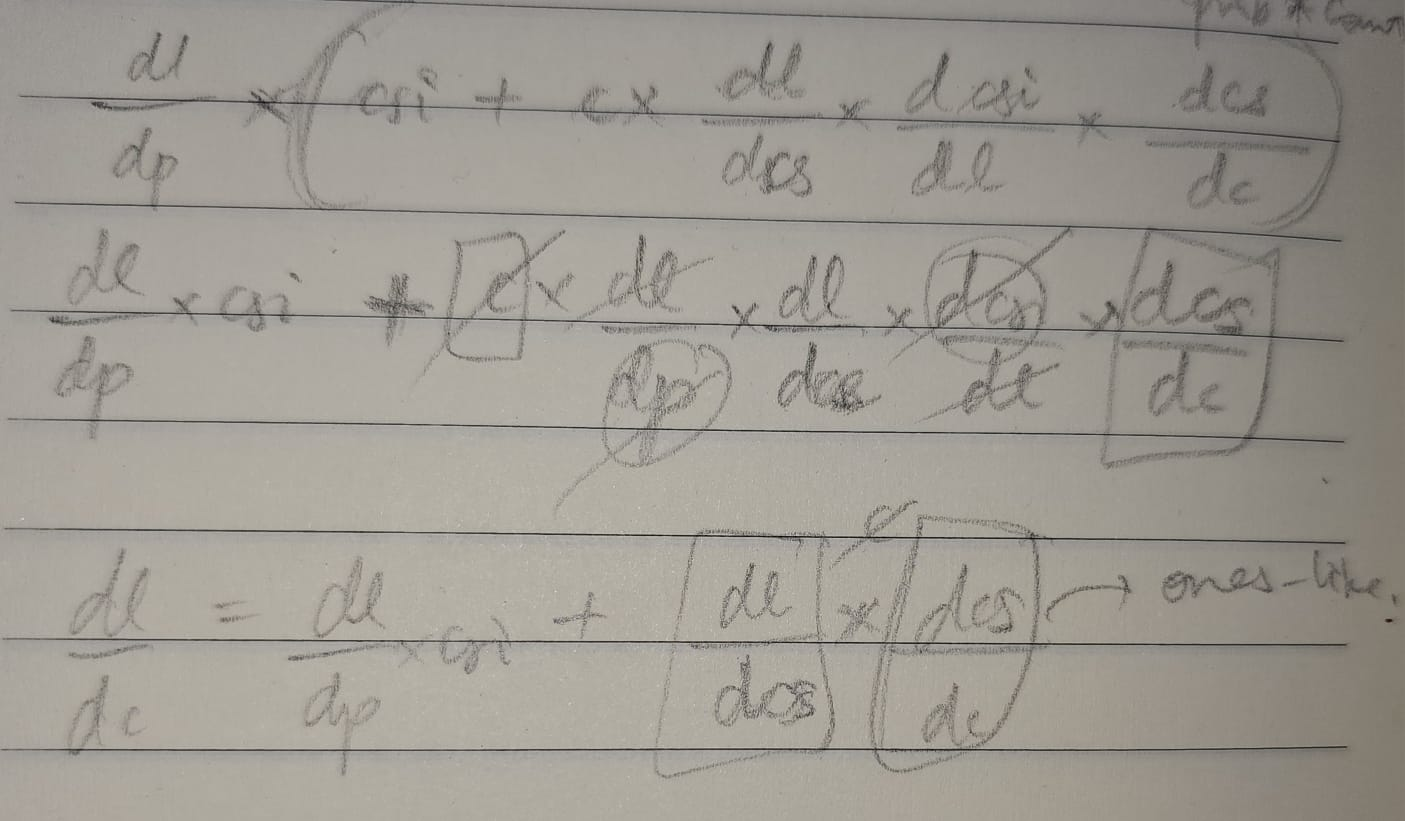

del(loss)/del(logits):
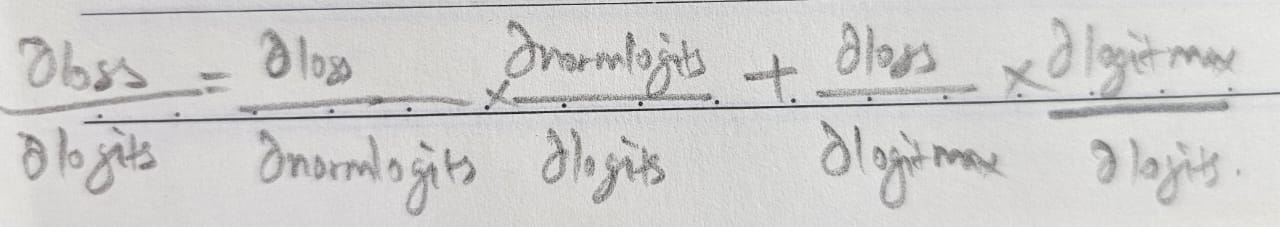

For gradients backprop involving matrix multiplications, its always helpful to take a smaller example and write down the equations for individual entries of the gradient matrix:
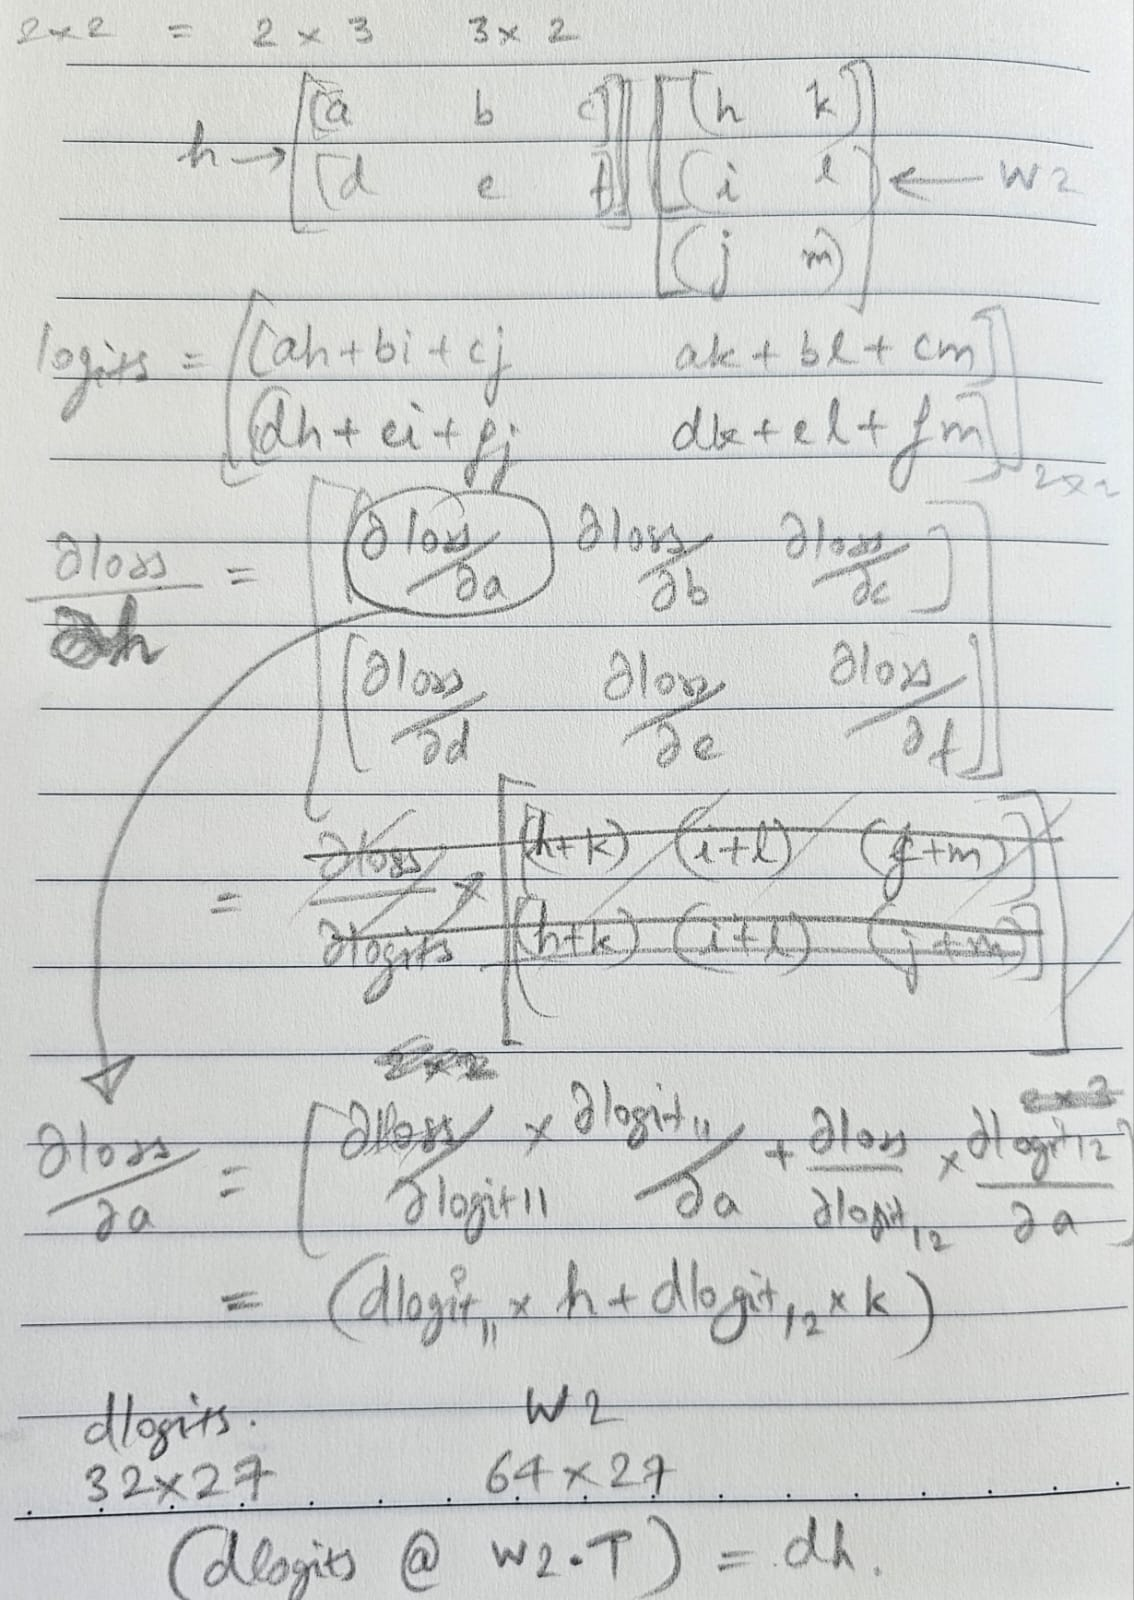

hpreact = gain*bnraw + bias
- `*` is element wise product operator
- bnraw is same shape as hpreact (32x64)
- bias is adjustment for the mean we subtracted and gain is the adjustment for the std we divided
- to remember the shapes of bias and gain is to see how the normalization was done
- since its batch norm, 32 examples are averaged out to get 64 dim mean
- 32 examples give 64 dim std

In [61]:
# bnraw   32x64
# gain       64 (broadcasted to element wise product with each row (each row has 64 hidden states))
# bias       64 (broadcasted to element wise sum with each row (each row has 64 hidden states))

Now, taking a small example we can understand how to calculate dbngain:
- here, hp - hpreact, g - bngain, b - bnbias, raw - bnraw, dhp - dhpreact

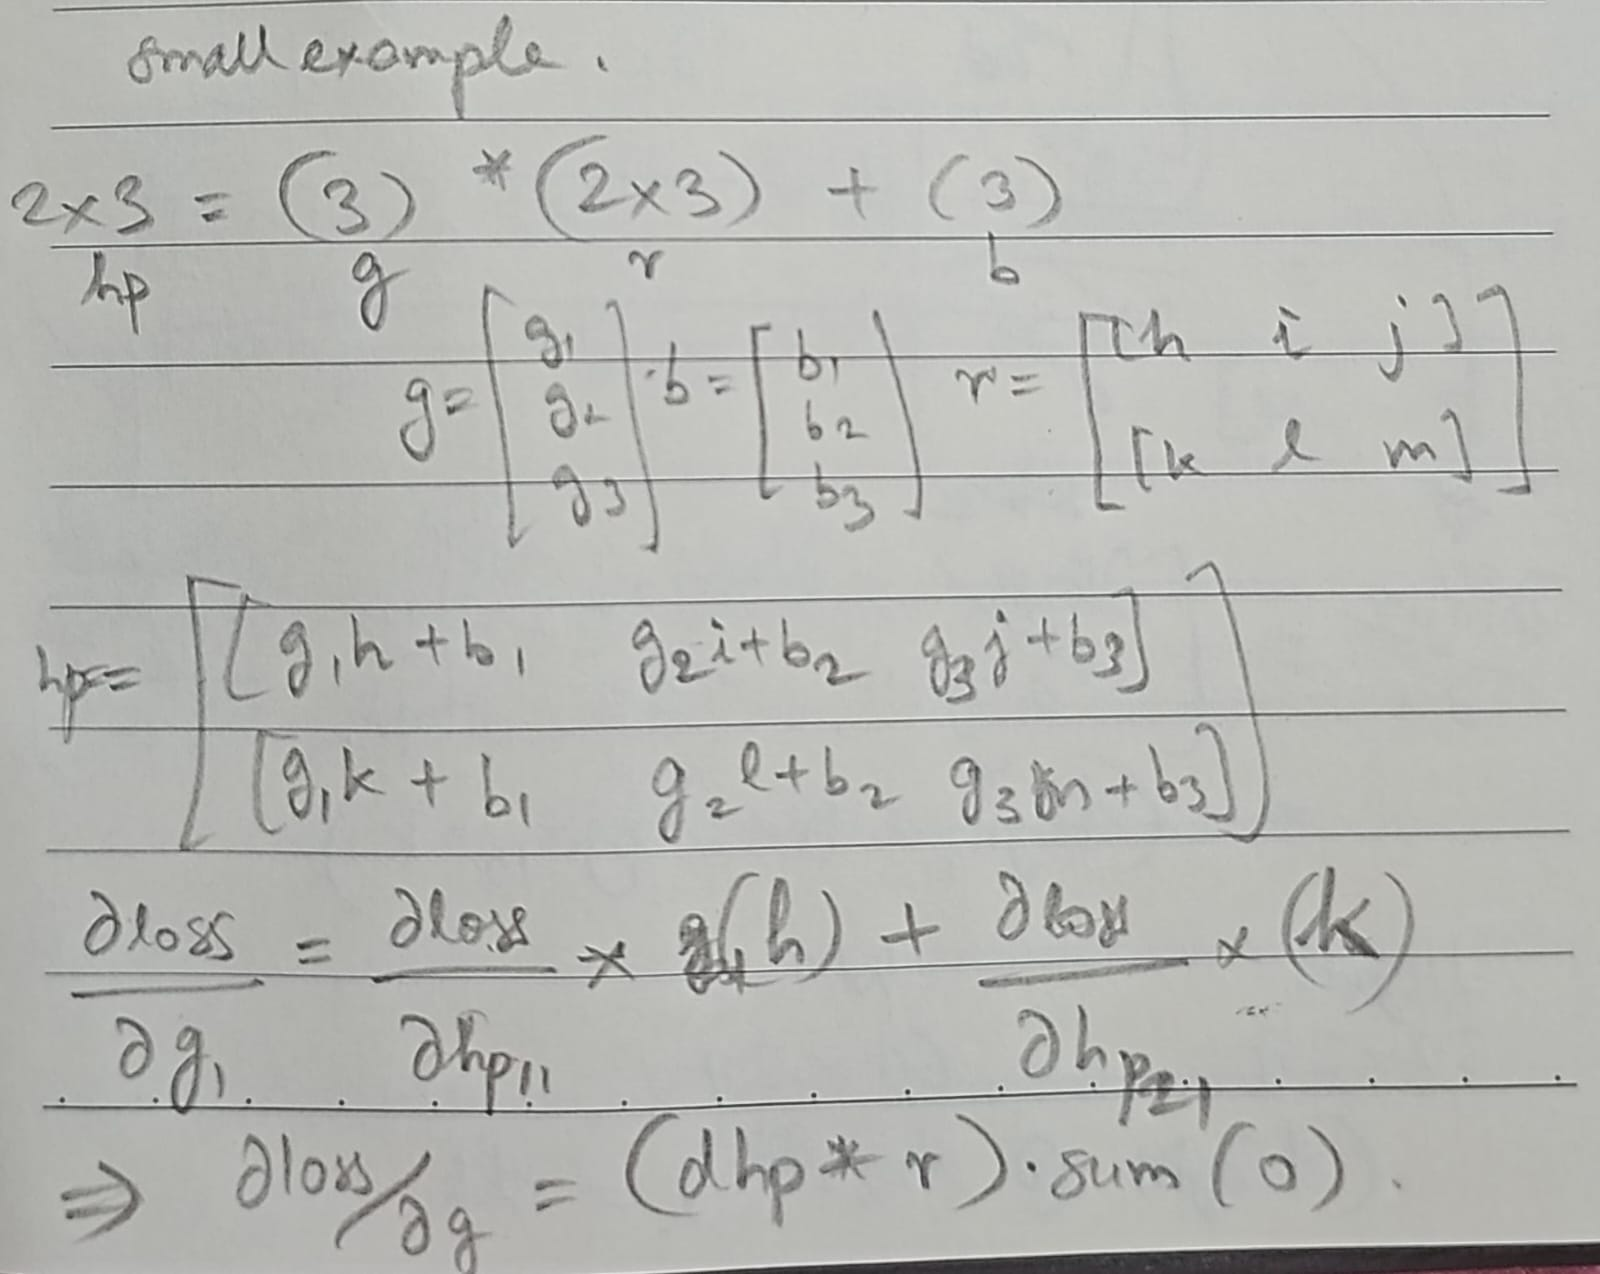

### implementation of backprop by hand
- elaborately broken down operations

torch.Size([27, 10])

In [97]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

# -----------------
# YOUR CODE HERE :)
# my # dlogprobs = -1.0*(torch.tensor([[1 if j == Yb[i] else 0 for j in range(vocab_size)] for i in range(n)]))/n
# efficient and elegant way:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = dlogprobs*(1.0/probs) # intuition is that wherever the prob is high dlogprobs is passed as is (if its 0 no change, if not the probs get updated for relevant Yb)
# if prob is low, and the actual answer is true then high penalty
dcounts_sum_inv = (dprobs*counts).sum(dim=1, keepdims = True) # keepdims very important
dcounts_sum = dcounts_sum_inv*(-counts_sum**-2)
dcounts = dprobs * counts_sum_inv + dcounts_sum * torch.ones_like(counts)
dnorm_logits = dcounts * counts
dlogit_maxes = -1*dnorm_logits.sum(1, keepdims = True) # same logic as dcounts_dum_inv
# logits contributes to both norm_logits and the logit_maxes, hence the derivative would be sum of individual path derivatives
dlogits = dnorm_logits*torch.ones_like(logits) + dlogit_maxes*F.one_hot(logits.max(1).indices, num_classes=logits.shape[1])
# product with torch.ones_like(logits) is redundant (included for completeness)
dh = dlogits @ W2.T # small example of the derivation in an image in above cells
# dh should be 32x64 => 32x27 @ 27x64
dW2 = h.T @ dlogits
db2 = dlogits.sum(0, keepdim=True) # db2 should be same dimension as b2 (27)
dhpreact = dh * (1 - h**2)
dbngain = (dhpreact*bnraw).sum(0, keepdim = True) # refer image for small example as proof
dbnbias = dhpreact.sum(0, keepdim = True) # similar to dbngain proof
dbnraw = dhpreact * bngain
dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim = True)
dbnvar = -0.5*(bnvar + 1e-5)**(-1.5) * dbnvar_inv
dbndiff2 = dbnvar * torch.ones_like(bndiff2)/(n-1) # bessel's correction (n-1) instead of n
dbndiff = 2*bndiff*dbndiff2 + torch.ones_like(bndiff)*bnvar_inv*dbnraw
dbnmeani = -1*dbndiff.sum(0, keepdim = True)
dhprebn = dbndiff + dbnmeani * torch.ones_like(hprebn)/n
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0, keepdim = True)
demb = dembcat.view(emb.shape[0], block_size, -1)
dC = torch.zeros((vocab_size, n_embd))
for i, idx in enumerate(Xb.view(-1).tolist()):
    dC[idx] += demb.view(-1, n_embd)[i]
# -----------------

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

All but some are exactly matching. The differences start coming in from dbndiff2 onwards, indicating there is some very small floating point error in the calculations making the gradients approx equal but not exact
- reason being division with (n-1) vs multiplication with (1.0/(n-1))

In [104]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

# -----------------
# YOUR CODE HERE :)
# my # dlogprobs = -1.0*(torch.tensor([[1 if j == Yb[i] else 0 for j in range(vocab_size)] for i in range(n)]))/n
# efficient and elegant way:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = dlogprobs*(1.0/probs) # intuition is that wherever the prob is high dlogprobs is passed as is (if its 0 no change, if not the probs get updated for relevant Yb)
# if prob is low, and the actual answer is true then high penalty
dcounts_sum_inv = (dprobs*counts).sum(dim=1, keepdims = True) # keepdims very important
dcounts_sum = dcounts_sum_inv*(-counts_sum**-2)
dcounts = dprobs * counts_sum_inv + dcounts_sum * torch.ones_like(counts)
dnorm_logits = dcounts * counts
dlogit_maxes = -1*dnorm_logits.sum(1, keepdims = True) # same logic as dcounts_dum_inv
# logits contributes to both norm_logits and the logit_maxes, hence the derivative would be sum of individual path derivatives
dlogits = dnorm_logits*torch.ones_like(logits) + dlogit_maxes*F.one_hot(logits.max(1).indices, num_classes=logits.shape[1])
# product with torch.ones_like(logits) is redundant (included for completeness)
dh = dlogits @ W2.T # small example of the derivation in an image in above cells
# dh should be 32x64 => 32x27 @ 27x64
dW2 = h.T @ dlogits
db2 = dlogits.sum(0, keepdim=True) # db2 should be same dimension as b2 (27)
dhpreact = dh * (1 - h**2)
dbngain = (dhpreact*bnraw).sum(0, keepdim = True) # refer image for small example as proof
dbnbias = dhpreact.sum(0, keepdim = True) # similar to dbngain proof
dbnraw = dhpreact * bngain
dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim = True)
dbnvar = -0.5*(bnvar + 1e-5)**(-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2)*dbnvar # bessel's correction (n-1) instead of n
dbndiff = 2*bndiff*dbndiff2 + torch.ones_like(bndiff)*bnvar_inv*dbnraw
dbnmeani = -1*dbndiff.sum(0, keepdim = True)
dhprebn = dbndiff + dbnmeani * torch.ones_like(hprebn)/n
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0, keepdim = True)
demb = dembcat.view(emb.shape[0], block_size, -1) # or better just emb.shape
dC = torch.zeros_like(C)
for i, idx in enumerate(Xb.view(-1).tolist()):
    dC[idx] += demb.view(-1, n_embd)[i]
# -----------------

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

Now exactly equal!

### implement backward prop in one go
- for each operation like cross entropy, batch norm

In [105]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.4631335735321045 diff: 0.0


In [106]:
# backward pass

# -----------------
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n
# -----------------

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


In [107]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [108]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
dhprebn = bngain*bnvar_inv/n*(n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0)) # non-trivial mathematical derivation!!
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


### Final exercise put all together

In [140]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass
from tqdm import tqdm
# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []
# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

    # kick off optimization
    for i in tqdm(range(max_steps)):
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

        # forward pass
        emb = C[Xb] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
        # Linear layer
        hprebn = embcat @ W1 + b1 # hidden layer pre-activation
        # BatchNorm layer
        # -------------------------------------------------------------
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # -------------------------------------------------------------
        # Non-linearity
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Yb) # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        # loss.backward() # use this for correctness comparisons, delete it later!

        # manual backprop! #swole_doge_meme
        # -----------------
        # YOUR CODE HERE :)

        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        dhpreact = dh * (1 - h**2)
        dbngain = (dhpreact*bnraw).sum(0)
        dbnbias = dhpreact.sum(0)
        dhprebn = bngain*bnvar_inv/n*(n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0)) # non-trivial mathematical derivation!!
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        dembcat = dhprebn @ W1.T
        demb = dembcat.view(emb.shape[0], block_size, -1) # or better just emb.shape
        dC = torch.zeros_like(C)
        for i, idx in enumerate(Xb.view(-1).tolist()):
            dC[idx] += demb.view(-1, n_embd)[i]
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
        # -----------------

        # update
        lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
        for p, grad in zip(parameters, grads):
          # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
            p.data += -lr * grad # new way of swole doge TODO: enable

        # track stats
        if i%1000==0:
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())


12297


  3%|▎         | 6876/200000 [00:34<16:03, 200.52it/s]


KeyboardInterrupt: 

In [131]:
# useful for checking your gradients
for p,g in zip(parameters, grads):
  cmp(str(tuple(p.shape)), g, p)

TypeError: all(): argument 'input' (position 1) must be Tensor, not bool

In [110]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [111]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xtest, Ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.703306198120117
val 2.7197277545928955
